In [11]:
#uzawa (outer) solve, method #1
def uzawa1(KKK,G,Nfem,nel,rhs_f,rhs_h):
    Vsol=numpy.zeros((Nfem),dtype=float)
    Psol=numpy.zeros((nel),dtype=float)
    Vsolmem=numpy.zeros((Nfem),dtype=float)
    Psolmem=numpy.zeros((nel),dtype=float)
    KKKmem=numpy.zeros((Nfem,Nfem),dtype=float)
    alpha=1e3
    tol=1e-6
    niter=250
    KKKmem=KKK
    
    V_diff = []
    P_diff = []
    
    for iter in range(0,niter):
        
        #solve for velocity
        B=rhs_f-numpy.matmul(G,Psol)
        B=numpy.linalg.solve(KKK,B)
        Vsol=B
        
        #solve for pressure
        Psol=Psol+alpha*(numpy.matmul(G.transpose(),Vsol)-rhs_h)
        
        #check for convergence
        V_diff.append(numpy.max(abs(Vsol-Vsolmem))/numpy.max(abs(Vsol)))
        P_diff.append(numpy.max(abs(Psol-Psolmem))/numpy.max(abs(Psol)))
        
        print('iteration:',iter,'V_diff:',V_diff[iter],'P_diff',P_diff[iter],'max(Psol)',numpy.max(Psol),end='\r')
        
        Psolmem=Psol
        Vsolmem=Vsol
        
        if max(V_diff[iter],P_diff[iter]) < tol or iter == niter-1 :
            print('')
            return (Vsol,Psol,V_diff,P_diff)
        

In [12]:
#importing packages etc.
print("importing pacakages")

import numpy as numpy
import math as math
import sys as sys
import scipy as scipy
from scipy import sparse
import matplotlib.pyplot as plt

#variable declaration
print("variable declaration")

m=4
ndof=2

Lx=1
Ly=1

nnx=25
nny=25

np=nnx*nny

nelx=nnx-1
nely=nny-1

nel=nelx*nely

penalty=1.0e7

viscosity=1.0e0
density=1.0e0

Nfem=np*ndof

eps=1.0e-10

gx=0
gy=1

#declaring arrays
print("declaring arrays")

x      = numpy.zeros((np),          dtype=float)
y      = numpy.copy(x)
u      = numpy.copy(x)
v      = numpy.copy(x)
A      = numpy.zeros((Nfem,Nfem),   dtype=float)
B      = numpy.zeros((Nfem),        dtype=float)
sol    = numpy.zeros((Nfem),        dtype=float)
icon   = numpy.zeros((m,nel),       dtype=int)
bc_fix = numpy.zeros((Nfem),        dtype=bool)
bc_val = numpy.zeros((Nfem),        dtype=float)
N      = numpy.zeros((m),           dtype=float)
dNdx   = numpy.copy(N)
dNdy   = numpy.copy(N)
dNdr   = numpy.copy(N)
dNds   = numpy.copy(N)
jcb    = numpy.zeros((2,2),         dtype=float)
jcbi   = numpy.copy(jcb)
Bmat   = numpy.zeros((3,ndof*m),    dtype=float)
Kmat   = numpy.zeros(shape=(3,3))
Cmat   = numpy.zeros(shape=(3,3))
KKK    = numpy.zeros((Nfem,Nfem),   dtype=float)
G      = numpy.zeros((Nfem,nel),    dtype=float)
rhs_f  = numpy.zeros((Nfem),        dtype=float)
rhs_h  = numpy.zeros((nel),         dtype=float)

Kmat[0,0]=1.0e0 ; Kmat[0,1]=1.0e0 ; Kmat[0,2]=0.0e0  
Kmat[1,0]=1.0e0 ; Kmat[1,1]=1.0e0 ; Kmat[1,2]=0.0e0  
Kmat[2,0]=0.0e0 ; Kmat[2,1]=0.0e0 ; Kmat[2,2]=0.0e0  

Cmat[0,0]=2.0e0 ; Cmat[0,1]=0.0e0 ; Cmat[0,2]=0.0e0  
Cmat[1,0]=0.0e0 ; Cmat[1,1]=2.0e0 ; Cmat[1,2]=0.0e0  
Cmat[2,0]=0.0e0 ; Cmat[2,1]=0.0e0 ; Cmat[2,2]=1.0e0  

#grid point setup
print("grid point setup")

counter=0
for j in range (0,nely+1):
    for i in range (0,nelx+1):
        x[counter]=i*Lx/nelx
        y[counter]=j*Ly/nely
        counter += 1

#connectivity
print("connectivity")

counter=0
for j in range (0,nely):
    for i in range (0,nelx):
        icon[0,counter]=i+   j*(nelx+1)
        icon[1,counter]=i+1+ j*(nelx+1)
        icon[2,counter]=i+1+(j+1)*(nelx+1)
        icon[3,counter]=i  +(j+1)*(nelx+1)
        counter += 1
        
# for iel in range (0,nel):
#         print ("iel=",iel)
#         print ("node 1",icon[0][iel],"at pos.",x[icon[0][iel-1]], y[icon[0][iel-1]])
#         print ("node 2",icon[1][iel],"at pos.",x[icon[1][iel-1]], y[icon[1][iel-1]])
#         print ("node 3",icon[2][iel],"at pos.",x[icon[2][iel-1]], y[icon[2][iel-1]])
#         print ("node 4",icon[3][iel],"at pos.",x[icon[3][iel-1]], y[icon[3][iel-1]])

#define boundary conditions
print("define boundary conditions")

for i in range (0,np):
    if x[i] < eps:
        bc_fix[i*ndof] = True   ; bc_val[i*ndof]=0.0e0
        bc_fix[i*ndof+1]=True ; bc_val[i*ndof+1]=0.0e0
    if x[i] > (Lx-eps):
        bc_fix[i*ndof] = True   ; bc_val[i*ndof]=0.0e0
        bc_fix[i*ndof+1]=True ; bc_val[i*ndof+1]=0.0e0
    if y[i] < eps:
        bc_fix[i*ndof] = True   ; bc_val[i*ndof]=0.0e0
        bc_fix[i*ndof+1]=True ; bc_val[i*ndof+1]=0.0e0
    if y[i] > (Ly-eps):
        bc_fix[i*ndof] = True   ; bc_val[i*ndof]=0.0e0
        bc_fix[i*ndof+1]=True ; bc_val[i*ndof+1]=0.0e0

# for i in range (0,np):
#     if bc_fix[i*ndof] == True:  
#         print (counter,x[i],y[i],u[i])
#     if bc_fix[i*ndof+1] == True:
#         print (counter,x[i],y[i],v[i])

#build FE matrix
print("build FE matrix")

for iel in range (0,nel):
        
    Kel = numpy.zeros((m*ndof,m*ndof),dtype=float)
    Gel = numpy.zeros((m*ndof,1),dtype=float)
    #list comprehension
    fel = [0 for i in range(0,m*ndof)]
    
    for iq in range (-1,3,2):
        for jq in range (-1,3,2):
            rq=iq/math.sqrt(3.0)
            sq=jq/math.sqrt(3.0)
            
            wq=1.0*1.0

            N[0]=0.25*(1.0-rq)*(1.0-sq)
            N[1]=0.25*(1.0+rq)*(1.0-sq)
            N[2]=0.25*(1.0+rq)*(1.0+sq)
            N[3]=0.25*(1.0-rq)*(1.0+sq)

            dNdr[0]= - 0.25e0*(1.0e0-sq)   ;   dNds[0]= - 0.25e0*(1.0e0-rq)
            dNdr[1]= + 0.25e0*(1.0e0-sq)   ;   dNds[1]= - 0.25e0*(1.0e0+rq)
            dNdr[2]= + 0.25e0*(1.0e0+sq)   ;   dNds[2]= + 0.25e0*(1.0e0+rq)
            dNdr[3]= - 0.25e0*(1.0e0+sq)   ;   dNds[3]= + 0.25e0*(1.0e0-rq)
            
            jcb = numpy.zeros((2,2),dtype=float)
            for k in range (0,m):
                jcb[0,0]=jcb[0,0]+dNdr[k]*x[icon[k,iel]]
                jcb[0,1]=jcb[0,1]+dNdr[k]*y[icon[k,iel]]
                jcb[1,0]=jcb[1,0]+dNds[k]*x[icon[k,iel]]
                jcb[1,1]=jcb[1,1]+dNds[k]*y[icon[k,iel]]
    
            jcob=jcb[0,0]*jcb[1,1]-jcb[1,0]*jcb[0,1]

            jcbi[0,0]=    jcb[1,1] /jcob
            jcbi[0,1]=  - jcb[0,1] /jcob
            jcbi[1,0]=  - jcb[1,0] /jcob
            jcbi[1,1]=    jcb[0,0] /jcob
            
            xq=0.0e0
            yq=0.0e0
            uq=0.0e0
            vq=0.0e0
            exxq=0.0e0
            eyyq=0.0e0
            exyq=0.0e0
            for k in range(0,m):
                xq=xq+N[k]*x[icon[k,iel]]
                yq=yq+N[k]*y[icon[k,iel]]
                uq=uq+N[k]*u[icon[k,iel]]
                vq=vq+N[k]*v[icon[k,iel]]
                dNdx[k]=jcbi[0,0]*dNdr[k]+jcbi[0,1]*dNds[k]
                dNdy[k]=jcbi[1,0]*dNdr[k]+jcbi[1,1]*dNds[k]
                exxq=exxq+ dNdx[k]*u[icon[k,iel]]
                eyyq=eyyq+ dNdy[k]*v[icon[k,iel]]
                exyq=exyq+ dNdx[k]*v[icon[k,iel]] *0.5e0 + dNdy[k]*u[icon[k,iel]] *0.5e0
                
            for i in range(0,m):
                i1=2*i
                i2=2*i+1
                Bmat[0,i1]=dNdx[i] ; Bmat[0,i2]=0
                Bmat[1,i1]=0       ; Bmat[1,i2]=dNdy[i]
                Bmat[2,i1]=dNdy[i] ; Bmat[2,i2]=dNdx[i]
                
            Kel=Kel+numpy.matmul(Bmat.transpose(),numpy.matmul(viscosity*Cmat,Bmat))*wq*jcob
            
            for i in range(0,m):
                i1=2*i
                i2=2*i+1
                fel[i1]=fel[i1]+N[i]*jcob*wq*density*gx
                fel[i2]=fel[i2]+N[i]*jcob*wq*density*gy
                #Bel[i1]=Bel[i1]+N[i]*jcob*wq*b1[xq,yq]
                #Bel[i2]=Bel[i2]+N[i]*jcob*wq*b2[xq,yq]
                Gel[i1,0]=Gel[i1,0]-dNdx[i]*jcob*wq
                Gel[i2,0]=Gel[i2,0]-dNdy[i]*jcob*wq           
    
    #assemble
    for k1 in range(0,m):
        ik=icon[k1,iel]
        for i1 in range(0,ndof):
            ikk=ndof*(k1)+i1
            m1=ndof*(ik)+i1
            for k2 in range(0,m):
                jk=icon[k2,iel]
                for i2 in range(0,ndof):
                    jkk=ndof*(k2)+i2
                    m2=ndof*(jk)+i2
                    KKK[m1,m2]=KKK[m1,m2]+Kel[ikk,jkk]
            rhs_f[m1]=rhs_f[m1]+fel[ikk]
            G[m1,iel]=G[m1,iel]+Gel[ikk,0]
                                       
#impose b.c.
print("impose b.c.")

for i in range(0,Nfem):
    if bc_fix[i]==True:
        Aref=KKK[i,i]
        for j in range(0,Nfem):
            rhs_f[j]=rhs_f[j]-KKK[i,j]*bc_val[i]
            KKK[i,j]=0.0
            KKK[j,i]=0.0
        KKK[i,i]=Aref
        rhs_f[i]=Aref*bc_val[i]
        
        for j in range(0,nel):
            rhs_h[j]=rhs_h[j]-G[i,j]*bc_val[i]
            G[i,j]=0.0
        
print("minimum KKK =",numpy.min(KKK))
print("maximum KKK =",numpy.max(KKK))
print("minimum rhs_f =",numpy.min(rhs_f))
print("maximum rhs_f =",numpy.max(rhs_f))

(Vsol,Psol,V_diff,P_diff)=uzawa1(KKK,G,Nfem,nel,rhs_f,rhs_h)

# #solve system
# print("solve system")
# #sol=scipy.sparse.linalg.cg(A,B)
# sol=numpy.linalg.solve(A,B)

# # counter=0
# # for z in sol:
# #     counter+=1
# #     print(z,counter)
    

# #notation "[0][...]" because of tuple when using CG
# for i in range(0,np):
# #     u[i]=sol[0][i*ndof]
# #     v[i]=sol[0][i*ndof+1]
#     u[i]=sol[i*ndof]
#     v[i]=sol[i*ndof+1]

# print("minimum u =",min(u), "minimum v",min(v))
# print("maximum u =",max(u), "maximum v",max(v))

print("done")

importing pacakages
variable declaration
declaring arrays
grid point setup
connectivity
define boundary conditions
build FE matrix
impose b.c.
minimum KKK = -1.0
maximum KKK = 4.0
minimum rhs_f = 0.0
maximum rhs_f = 0.00173611111111
iteration: 249 V_diff: 0.00720185536886 P_diff 4.93931320715e-06 max(Psol) 0.479487108669
done


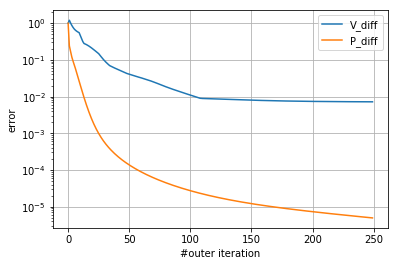

In [3]:
    plt.plot(V_diff,label='V_diff')
    plt.plot(P_diff,label='P_diff')
    plt.yscale('log')
    plt.ylabel('error')
    plt.xlabel('#outer iteration')
    plt.grid()
    plt.legend()
    plt.show()